### 1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
### 3. Повторить п.2, но используя уже не медиану, а max
### 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2
import itertools
import nltk
nltk.download('stopwords')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score 
from sklearn.metrics import precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annasmelova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Пользователи и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


1. Получаем векторные представления новостей

In [4]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 28.5 s, sys: 343 ms, total: 28.8 s
Wall time: 30.3 s


In [8]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 32s, sys: 2.05 s, total: 4min 34s
Wall time: 4min 50s


In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 24s, sys: 1.18 s, total: 1min 25s
Wall time: 1min


In [11]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.061058853),
 (4, 0.04477719),
 (16, 0.057859305),
 (19, 0.5869941),
 (23, 0.22979839)]

In [13]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сотрудник выяснить данные взрыв район миссия статья
topic_1: ракета фонд продукция сколково китай китайский станция
topic_2: исследователь земля русский американский животное nn восток
topic_3: система проект сша американский экономический область новый
topic_4: обнаружить древний армия спутник след агентство иран
topic_5: млрд эксперт рынок нефть сша население повышение
topic_6: россия путин глава государство российский санкция министр
topic_7: учёный луна смерть заболевание болезнь возраст век
topic_8: сша территория сторона nn москва россия власть
topic_9: писать банк газпром километр письмо экономика nn
topic_10: погибнуть корабль источник российский рак область море
topic_11: учёный научный nn университет наука журнал автор
topic_12: самолёт военный операция тело полёт клетка война
topic_13: ребёнок мозг солнечный семья страдать развитие земля
topic_14: ветер офицер nn умереть захватить затмение ресторан
topic_15: украина гражданин украинский экономика киев россия всё
top

Векторное представление новости

In [14]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.000000,0.024788,0.0,0.085489,0.0,0.0,...,0.000000,0.0,0.000000,0.433543,0.068963,0.0,0.0,0.000000,0.011808,0.000000
1,4896,0.629978,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.302661,0.0,0.0,0.000000,0.045897,0.000000
2,4897,0.000000,0.0,0.0,0.059294,0.055609,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.581227,0.0,0.0,0.000000,0.248963,0.000000
3,4898,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.189953,0.0,0.026948,0.000000,0.151687,0.0,0.0,0.156337,0.442513,0.023514
4,4899,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.349597,0.188163,0.105043,0.0,0.0,0.000000,0.000000,0.000000


Векторные представления пользователей

In [16]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [17]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [18]:
#user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, agg_func='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if agg_func == 'median':
        user_vector = np.median(user_vector, 0)
    elif agg_func == 'max':
        user_vector = np.max(user_vector, 0)
    else:
        user_vector = np.mean(user_vector, 0)
    return user_vector

Получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [19]:
def add_string_to_df(df, string):
    data = df.copy()
    data.loc[len(data)] = string
    return data

In [20]:
results = pd.DataFrame(columns=['type','roc_auc','precision','recall','f_score','threshold'])

#### Mean

In [21]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x,'mean'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.071682,0.009119,0.080052,0.069320,0.028124,0.002849,0.056202,0.008550,0.044181,...,0.079824,0.017710,0.072664,0.072414,0.008174,0.039498,0.005811,0.010213,0.001990,0.014028
1,u108690,0.113619,0.005741,0.019574,0.023233,0.000000,0.036734,0.065238,0.040729,0.184826,...,0.144401,0.015322,0.047540,0.040349,0.007495,0.021785,0.008244,0.004110,0.021490,0.001919
2,u108339,0.189806,0.000000,0.027633,0.028385,0.001714,0.011223,0.023736,0.093851,0.053235,...,0.013880,0.050810,0.117277,0.063308,0.001851,0.006695,0.006268,0.002130,0.014542,0.000000


In [22]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [23]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.071682,0.009119,0.080052,0.069320,0.028124,0.002849,0.056202,0.008550,0.044181,...,0.017710,0.072664,0.072414,0.008174,0.039498,0.005811,0.010213,0.001990,0.014028,0
1,u108690,0.113619,0.005741,0.019574,0.023233,0.000000,0.036734,0.065238,0.040729,0.184826,...,0.015322,0.047540,0.040349,0.007495,0.021785,0.008244,0.004110,0.021490,0.001919,1
2,u108339,0.189806,0.000000,0.027633,0.028385,0.001714,0.011223,0.023736,0.093851,0.053235,...,0.050810,0.117277,0.063308,0.001851,0.006695,0.006268,0.002130,0.014542,0.000000,1


In [24]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [25]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [26]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09916207, 0.0433557 , 0.48826104, 0.14470737, 0.0675304 ,
       0.05377624, 0.09201602, 0.03453556, 0.09166561, 0.25160734])

Рассчитаем Precision, Recall, F_score

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.291107, F-Score=0.732, Precision=0.722, Recall=0.743


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1685   70]
 [  64  181]]


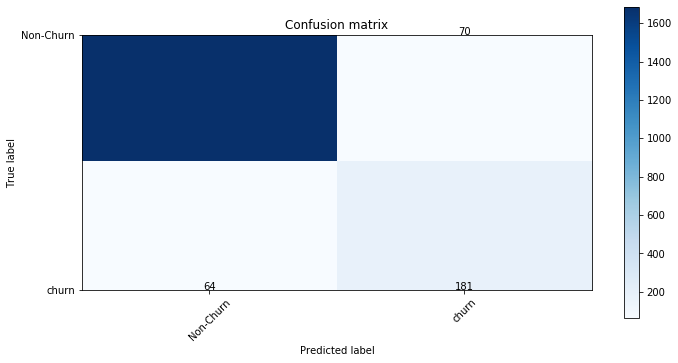

In [29]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
#font = {'size' : 15}

#plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [30]:
r_a = roc_auc_score(y_test, preds)
r_a

0.9671678585964301

In [31]:
mean_results = ['mean',r_a, precision[ix],recall[ix],fscore[ix],thresholds[ix]]
results = add_string_to_df(results, mean_results)
results

,type,roc_auc,precision,recall,f_score,threshold
0,mean,0.967168,0.722222,0.742857,0.732394,0.291107


#### Median

In [32]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x,'median'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.055478,0.010243,0.0,0.000000,0.058173,0.000000,0.000000,...,0.023069,0.000000,0.022079,0.012508,0.0,0.0,0.000000,0.0,0.000000,0.0
1,u108690,0.078153,0.0,0.000000,0.023511,0.0,0.009851,0.060015,0.026558,0.122567,...,0.108279,0.000000,0.051845,0.040413,0.0,0.0,0.006733,0.0,0.000000,0.0
2,u108339,0.189747,0.0,0.028908,0.015689,0.0,0.000000,0.031015,0.008404,0.017911,...,0.000000,0.008792,0.120062,0.054696,0.0,0.0,0.000000,0.0,0.016944,0.0


In [33]:
target = pd.read_csv("users_churn.csv")
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
preds = logreg.predict_proba(X_test)[:, 1]

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.262686, F-Score=0.736, Precision=0.701, Recall=0.776


In [37]:
r_a = roc_auc_score(y_test, preds)
r_a

0.9630211058782489

In [38]:
median_results = ['median',r_a, precision[ix],recall[ix],fscore[ix],thresholds[ix]]
results = add_string_to_df(results, median_results)
results

,type,roc_auc,precision,recall,f_score,threshold
0,mean,0.967168,0.722222,0.742857,0.732394,0.291107
1,median,0.963021,0.701107,0.775510,0.736434,0.262686


#### Max

In [39]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x,'max'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.430089,0.054711,0.240241,0.312061,0.168746,0.017095,0.126613,0.051298,0.173925,...,0.351246,0.093307,0.300561,0.371033,0.049043,0.205302,0.034867,0.061279,0.011939,0.048603
1,u108690,0.391663,0.034447,0.059151,0.054778,0.000000,0.101783,0.149416,0.133860,0.508455,...,0.400285,0.091933,0.108801,0.081286,0.033220,0.084044,0.021583,0.024660,0.075450,0.011512
2,u108339,0.377858,0.000000,0.058820,0.089480,0.010282,0.067336,0.041862,0.351810,0.243170,...,0.044149,0.245573,0.253947,0.157532,0.011109,0.029249,0.023946,0.012778,0.028805,0.000000


In [40]:
target = pd.read_csv("users_churn.csv")
X = pd.merge(user_embeddings, target, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [42]:
preds = logreg.predict_proba(X_test)[:, 1]

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.366018, F-Score=0.828, Precision=0.812, Recall=0.845


In [44]:
r_a = roc_auc_score(y_test, preds)
r_a

0.9834478748764464

In [45]:
max_results = ['max',r_a, precision[ix],recall[ix],fscore[ix],thresholds[ix]]
results = add_string_to_df(results, max_results)
results

,type,roc_auc,precision,recall,f_score,threshold
0,mean,0.967168,0.722222,0.742857,0.732394,0.291107
1,median,0.963021,0.701107,0.775510,0.736434,0.262686
2,max,0.983448,0.811765,0.844898,0.828000,0.366018


### Выводы

Лучшее качество показали "максимальные" эмбеддинги. Интерпретировать это можно так: при выборе максимальных значений вероятностей топиков, мы как бы фокусируемся на основных темах, которые предпочитает пользователь. Понятное дело, что неосновные топики получат также повышенную вероятность, но главные интересы не потеряются, а наоборот выделятся. При выборе средних (mean) значений, мы как бы размазываем интересы пользователя. Медианные значения показывают результат выше среднего(roc_auc немного просел, но зато recall и f-score выше) видимо потому, что данный показатель как бы тоже больше смещен в пользу интересов пользователей. 